## Step 1: Import Required Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt


## Step 2: Load and Normalize the Fashion MNIST Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Step 3: Resize Images and Convert to 3 Channels (Fixed)

In [3]:
def resize_and_repeat(image):
    image = tf.expand_dims(image, axis=-1)  # Add a channel dimension (28,28) -> (28,28,1)
    image_resized = tf.image.resize(image, (96, 96))  # Resize to 96x96
    image_resized = tf.repeat(image_resized, 3, axis=-1)  # Convert to 3 channels
    return image_resized

## Step 4: Preprocess Data Using tf.data.Dataset

In [4]:
def preprocess_data(x_data, y_data):
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    dataset = dataset.map(lambda x, y: (resize_and_repeat(x), y))
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)
    return dataset
train_dataset = preprocess_data(x_train, y_train)
test_dataset = preprocess_data(x_test, y_test)

## Step 5: Load Pre-trained MobileNetV2 Model

In [5]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Step 6: Create Feature Extractor Model

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=base_model.input, outputs=x)

## Step 7: Extract Features Using CNN

In [7]:
def extract_features(dataset):
    features = []
    labels = []
    for batch_images, batch_labels in dataset:
        batch_features = feature_extractor.predict(batch_images)
        features.append(batch_features)
        labels.append(batch_labels)
    return np.vstack(features), np.concatenate(labels)
train_features, y_train_extracted = extract_features(train_dataset)
test_features, y_test_extracted = extract_features(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━

## Step 8: Train SVM Classifier

In [8]:
svm_clf = SVC(kernel='linear', C=1.0)
svm_clf.fit(train_features, y_train_extracted)

SVC(kernel='linear')

## Step 9: Make Predictions

In [9]:
y_pred = svm_clf.predict(test_features)

## Step 10: Evaluate Model Performance

In [10]:
accuracy = accuracy_score(y_test_extracted, y_pred)
print(f'Model Accuracy: {accuracy:.4f}')
print('\nClassification Report:\n', classification_report(y_test_extracted, y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_test_extracted, y_pred))

Model Accuracy: 0.8757

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81      1000
           1       0.98      0.98      0.98      1000
           2       0.80      0.84      0.82      1000
           3       0.87      0.84      0.85      1000
           4       0.82      0.81      0.81      1000
           5       0.95      0.96      0.96      1000
           6       0.69      0.66      0.68      1000
           7       0.92      0.92      0.92      1000
           8       0.98      0.98      0.98      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


Confusion Matrix:
 [[828   1  26  30   1   0 107   0   7   0]
 [  2 976   6  12   0   0   3   0   1   0]
 [ 25   0 842   7  55   0  70   0   1   0]
 [ 48  10  26 842  30   0  42   0   2   0]
 

## Step 11: Visualize Predictions

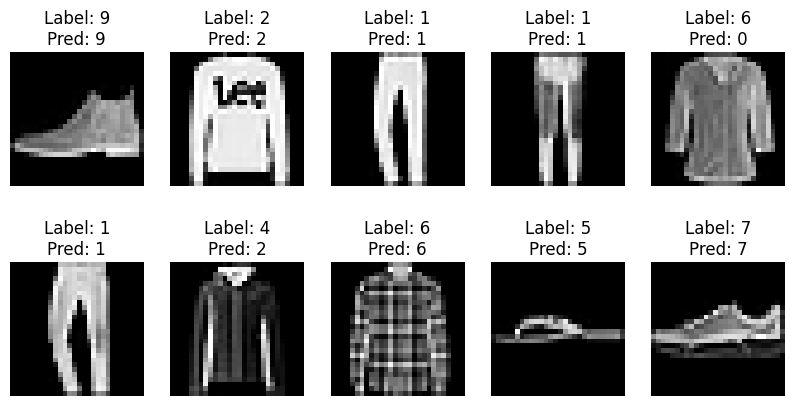

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for ax, image, label, pred in zip(axes.ravel(), x_test[:10], y_test[:10], y_pred[:10]):
    ax.set_axis_off()
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Label: {label}\nPred: {pred}')
plt.show()